In [1]:
import numpy as np
import pandas as pd
from keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import load_model
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from scipy.stats import uniform, shapiro, wilcoxon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from scipy.stats import ttest_rel
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Bidirectional, GlobalMaxPool1D, LSTM

import prepare_data as prep
from prepare_data import DataPreprocessor
from importlib import reload
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

reload(prep)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Radosz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'prepare_data' from 'd:\\Projects\\toxic-comment-classification\\prepare_data.py'>

In [2]:
prepData = DataPreprocessor("jigsaw-toxic-comment-classification-challenge/train.csv")


prepData.load_data()
prepData.preprocess_data()
X, y = prepData.get_XY()


                      id                                       comment_text  \
0       0000997932d777bf  explanation\nwhy the edits made under my usern...   
1       000103f0d9cfb60f  d'aww! he matches this background colour i'm s...   
2       000113f07ec002fd  hey man, i'm really not trying to edit war. it...   
3       0001b41b1c6bb37e  "\nmore\ni can't make any real suggestions on ...   
4       0001d958c54c6e35  you, sir, are my hero. any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::and for the second time of asking, when ...   
159567  ffea4adeee384e90  you should be ashamed of yourself \n\nthat is ...   
159568  ffee36eab5c267c9  spitzer \n\numm, theres no actual article for ...   
159569  fff125370e4aaaf3  and it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nand ... i really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insul

In [ ]:
testData = DataPreprocessor("jigsaw-toxic-comment-classification-challenge/merged_test_data.csv")

testData.load_data()
testData.filter_unlabeled_data()
testData.preprocess_data()
X_test_data, y_test_data = prepData.get_XY()


FileNotFoundError: [Errno 2] No such file or directory: 'jigsaw-toxic-comment-classification-challenge/merged_test_data.csv'

In [3]:
# Zmniana wartości klas w binarne

mlb = LabelBinarizer()
y_binary = mlb.fit_transform(y)

X_notoken = X

# Tokenizacja danych tekstowych
max_words = 20000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=max_len)

# Podział metodą train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_binary, test_size=0.2, random_state=42)

print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

# Binarize the labels
y_test_binary = mlb.fit_transform(y_test_data)

# Tokenize and pad the test data
X_test_data_seq = tokenizer.texts_to_sequences(X_test_data)
X_test_data_padded = pad_sequences(X_test_data_seq, maxlen=max_len)

print(X_test_data_padded.shape)
print(y_test_binary.shape)
print(X_test_data_padded)

X_train (127656, 150)
X_test (31915, 150)
y_train (127656, 6)
y_test (31915, 6)


NameError: name 'y_test_data' is not defined

In [ ]:
# Tokenizacja danych testowych

mlb = LabelBinarizer()
y_binary_test = mlb.fit_transform(y_test_data)

# Tokenizacja danych tekstowych
max_words = 20000
max_len = 150
tokenizer_test = Tokenizer(num_words=max_words)
tokenizer_test.fit_on_texts(X_test_data)
X_seq_test = tokenizer.texts_to_sequences(X_test_data)
X_padded_test = pad_sequences(X_seq_test, maxlen=max_len)

print(X_padded_test)
print(y_binary_test)

[[    0     0     0 ...  4170  2062   836]
 [    0     0     0 ...   467  7480   106]
 [    0     0     0 ...  2174   625   348]
 ...
 [    0     0     0 ...  2562 11806  3724]
 [    0     0     0 ...   231    68    51]
 [    0     0     0 ...   259  1456  1738]]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


CNN HYPERPARAMETERS

In [ ]:
space = {
    'max_len': hp.choice('max_len', [100, 200, 300]),
    'embed_dim': hp.choice('embed_dim', [64, 128, 256]),
    'filters': hp.choice('filters', [64, 128, 256]),
    'kernel_size': hp.choice('kernel_size', [3, 5, 7]),
    'dense_units': hp.choice('dense_units', [64, 128, 256]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'epochs': hp.choice('epochs', [3]),
}

def pad_sequences_custom(sequences, max_len):
    return np.array([np.pad(seq, (0, max_len - len(seq)), mode='constant')[:max_len] for seq in sequences])

def objective(params):
    # Cross-validation setup
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_scores_cnn = []
    
    # Define the CNN model
    inputs = Input(shape=(params['max_len'],))
    embedding = Embedding(input_dim=max_words, output_dim=params['embed_dim'], input_length=params['max_len'])(inputs)
    conv1 = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu')(embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation='relu')(pool1)
    pool2 = GlobalMaxPooling1D()(conv2)
    dense1 = Dense(params['dense_units'], activation='relu')(pool2)
    dropout = Dropout(params['dropout_rate'])(dense1)
    outputs = Dense(6, activation='sigmoid')(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    for train_index, val_index in kf.split(X_train):
        print(train_index)
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Adjust the input data to match max_len
        X_train_fold = pad_sequences_custom(X_train_fold, params['max_len'])
        X_val_fold = pad_sequences_custom(X_val_fold, params['max_len'])
        
        # Define callbacks
        checkpoint = ModelCheckpoint('best_model_cnn.tf', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)

        # Train the model
        history_cnn = model.fit(X_train_fold, y_train_fold, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop])

        # Evaluate the model
        val_preds = model.predict(X_val_fold)
        val_preds_binary = (val_preds > 0.5).astype(int)
        f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
        val_scores_cnn.append(f1)

    # Calculate the average F1 score over all folds
    avg_f1 = np.mean(val_scores_cnn)
    
    # Return the negative average F1 score to minimize
    return {'loss': -avg_f1, 'status': STATUS_OK}

# Initialize Trials object to keep track of results
trials = Trials()

# Run hyperparameter optimization
best_cnn = fmin(objective, space, algo=tpe.rand.suggest, max_evals=2, trials=trials)

# Print the best hyperparameters
print('Best hyperparameters:', best_cnn)

[    1     2     4 ... 12758 12763 12765]            
Epoch 1/3                                            

133/133 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.4072
                                                     
Epoch 1: val_loss improved from inf to 0.11323, saving model to best_model_cnn.tf

  0%|          | 0/2 [00:25<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



133/133 [==============================] - 24s 165ms/step - loss: 0.2125 - accuracy: 0.4072 - val_loss: 0.1132 - val_accuracy: 0.8447

Epoch 2/3                                            

133/133 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 0.6167
                                                     
Epoch 2: val_loss improved from 0.11323 to 0.08617, saving model to best_model_cnn.tf

  0%|          | 0/2 [00:47<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



133/133 [==============================] - 22s 163ms/step - loss: 0.1095 - accuracy: 0.6167 - val_loss: 0.0862 - val_accuracy: 0.9948

Epoch 3/3                                            

133/133 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.7182
                                                     
Epoch 3: val_loss improved from 0.08617 to 0.06738, saving model to best_model_cnn.tf

  0%|          | 0/2 [01:10<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



133/133 [==============================] - 23s 174ms/step - loss: 0.0565 - accuracy: 0.7182 - val_loss: 0.0674 - val_accuracy: 0.9948

133/133 [==============================] - 2s 11ms/step

[    0     1     2 ... 12762 12763 12764]            
Epoch 1/3                                            

133/133 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.7790
                                                     
Epoch 1: val_loss improved from inf to 0.04036, saving model to best_model_cnn.tf

  0%|          | 0/2 [01:35<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



133/133 [==============================] - 23s 171ms/step - loss: 0.0511 - accuracy: 0.7790 - val_loss: 0.0404 - val_accuracy: 0.9944

Epoch 2/3                                            

133/133 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.8312
                                                     
Epoch 2: val_loss did not improve from 0.04036

133/133 [==============================] - 22s 165ms/step - loss: 0.0340 - accuracy: 0.8312 - val_loss: 0.0413 - val_accuracy: 0.9944

Epoch 3/3                                            

133/133 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.8881
                                                     
Epoch 3: val_loss did not improve from 0.04036

133/133 [==============================] - 21s 155ms/step - loss: 0.0284 - accuracy: 0.8881 - val_loss: 0.0434 - val_accuracy: 0.9944

Epoch 3: early stopping                              

133/133 [==============================] - 1s 10ms/step


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



133/133 [==============================] - 23s 171ms/step - loss: 0.0350 - accuracy: 0.8877 - val_loss: 0.0256 - val_accuracy: 0.9944

Epoch 2/3                                            

133/133 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.8817
                                                     
Epoch 2: val_loss improved from 0.02558 to 0.02476, saving model to best_model_cnn.tf

  0%|          | 0/2 [03:04<?, ?trial/s, best loss=?]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



133/133 [==============================] - 22s 167ms/step - loss: 0.0279 - accuracy: 0.8817 - val_loss: 0.0248 - val_accuracy: 0.9944

Epoch 3/3                                            

133/133 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.8563
                                                     
Epoch 3: val_loss did not improve from 0.02476

133/133 [==============================] - 20s 149ms/step - loss: 0.0234 - accuracy: 0.8563 - val_loss: 0.0263 - val_accuracy: 0.9937

133/133 [==============================] - 1s 10ms/step

[    1     2     4 ... 12758 12763 12765]                                       
Epoch 1/3                                                                       

67/67 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.5617
                                                                                
Epoch 1: val_loss improved from inf to 0.13462, saving model to best_model_cnn.tf

 50%|█████     | 1/2 

INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



67/67 [==============================] - 9s 127ms/step - loss: 0.2506 - accuracy: 0.5617 - val_loss: 0.1346 - val_accuracy: 0.9948

Epoch 2/3                                                                       

67/67 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.7149
                                                                                
Epoch 2: val_loss improved from 0.13462 to 0.10181, saving model to best_model_cnn.tf

 50%|█████     | 1/2 [03:44<03:26, 206.86s/trial, best loss: -0.422904329577593]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



67/67 [==============================] - 9s 128ms/step - loss: 0.1391 - accuracy: 0.7149 - val_loss: 0.1018 - val_accuracy: 0.9948

Epoch 3/3                                                                       

67/67 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.7541
                                                                                
Epoch 3: val_loss improved from 0.10181 to 0.09469, saving model to best_model_cnn.tf

 50%|█████     | 1/2 [03:52<03:26, 206.86s/trial, best loss: -0.422904329577593]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



67/67 [==============================] - 8s 124ms/step - loss: 0.0965 - accuracy: 0.7541 - val_loss: 0.0947 - val_accuracy: 0.9948

133/133 [==============================] - 1s 7ms/step

[    0     1     2 ... 12762 12763 12764]                                       
Epoch 1/3                                                                       

67/67 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.7300
                                                                                
Epoch 1: val_loss improved from inf to 0.06503, saving model to best_model_cnn.tf

 50%|█████     | 1/2 [04:02<03:26, 206.86s/trial, best loss: -0.422904329577593]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



67/67 [==============================] - 8s 123ms/step - loss: 0.0815 - accuracy: 0.7300 - val_loss: 0.0650 - val_accuracy: 0.9944

Epoch 2/3                                                                       

67/67 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.8059
                                                                                
Epoch 2: val_loss improved from 0.06503 to 0.05463, saving model to best_model_cnn.tf

 50%|█████     | 1/2 [04:10<03:26, 206.86s/trial, best loss: -0.422904329577593]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



67/67 [==============================] - 8s 125ms/step - loss: 0.0525 - accuracy: 0.8059 - val_loss: 0.0546 - val_accuracy: 0.9944

Epoch 3/3                                                                       

67/67 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9354
                                                                                
Epoch 3: val_loss did not improve from 0.05463

67/67 [==============================] - 8s 113ms/step - loss: 0.0368 - accuracy: 0.9354 - val_loss: 0.0580 - val_accuracy: 0.9944

133/133 [==============================] - 1s 7ms/step

[    0     3     8 ... 12762 12764 12765]                                       
Epoch 1/3                                                                       

67/67 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.8701
                                                                                
Epoch 1: val_loss improved from inf to 0.03134, saving mode

INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



67/67 [==============================] - 8s 126ms/step - loss: 0.0453 - accuracy: 0.8701 - val_loss: 0.0313 - val_accuracy: 0.9944

Epoch 2/3                                                                       

67/67 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9215
                                                                                
Epoch 2: val_loss improved from 0.03134 to 0.03117, saving model to best_model_cnn.tf

 50%|█████     | 1/2 [04:37<03:26, 206.86s/trial, best loss: -0.422904329577593]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



67/67 [==============================] - 10s 147ms/step - loss: 0.0356 - accuracy: 0.9215 - val_loss: 0.0312 - val_accuracy: 0.9944

Epoch 3/3                                                                       

67/67 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9154
                                                                                
Epoch 3: val_loss improved from 0.03117 to 0.03020, saving model to best_model_cnn.tf

 50%|█████     | 1/2 [04:46<03:26, 206.86s/trial, best loss: -0.422904329577593]INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



67/67 [==============================] - 9s 133ms/step - loss: 0.0303 - accuracy: 0.9154 - val_loss: 0.0302 - val_accuracy: 0.9944

133/133 [==============================] - 1s 7ms/step

100%|██████████| 2/2 [04:48<00:00, 144.35s/trial, best loss: -0.422904329577593]
Best hyperparameters: {'batch_size': 1, 'dense_units': 0, 'dropout_rate': 0.20660872434466018, 'embed_dim': 2, 'epochs': 0, 'filters': 0, 'kernel_size': 1, 'max_len': 1}


LSTM HYPERPARAMETERS

In [ ]:
space = {
    'max_len': hp.choice('max_len', [100, 200, 300]),
    'embed_dim': hp.choice('embed_dim', [64, 128, 256]),
    'lstm_units': hp.choice('lstm_units', [32, 64, 128]),
    'recurrent_dropout': hp.uniform('recurrent_dropout', 0.1, 0.3),
    'dense_units': hp.choice('dense_units', [32, 64, 128]),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.4),
    'batch_size': hp.choice('batch_size', [64, 128, 256]),
    'epochs': hp.choice('epochs', [3]),
}

def objective(params):
    # Cross-validation setup
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_scores_lstm = []
    inputs = Input(shape=(params['max_len'],))
    layer = Embedding(input_dim=max_words, output_dim=params['embed_dim'], input_length=params['max_len'])(inputs)
    layer = Bidirectional(LSTM(params['lstm_units'], return_sequences=True, recurrent_dropout=params['recurrent_dropout']))(layer)
    layer = GlobalMaxPool1D()(layer)
    layer = Dropout(params['dropout_rate'])(layer)
    layer = Dense(params['dense_units'], activation='relu')(layer)
    layer = Dropout(params['dropout_rate'])(layer)
    layer = Dense(6, activation='sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    for train_index, val_index in kf.split(X_train2):
        X_train_fold, X_val_fold = X_train2[train_index], X_train2[val_index]
        y_train_fold, y_val_fold = y_train2[train_index], y_train2[val_index]

        # Adjust the input data to match max_len
        X_train_fold = pad_sequences_custom(X_train_fold, params['max_len'])
        X_val_fold = pad_sequences_custom(X_val_fold, params['max_len'])
    
        checkpoint = ModelCheckpoint('save_best_model_lstm.tf', monitor='val_loss', verbose=1, save_best_only=True)
        early_stop = EarlyStopping(monitor='val_loss', patience=1)

        history_lstm = model.fit(X_train_fold, y_train_fold, batch_size=params['batch_size'], epochs=params['epochs'], validation_split=0.2, callbacks=[checkpoint, early_stop])

        # Evaluate the model
        val_preds = model.predict(X_val_fold)
        val_preds_binary = (val_preds > 0.5).astype(int)
        f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
        val_scores_lstm.append(f1)

    # Calculate the average F1 score over all folds
    avg_f1 = np.mean(val_scores_lstm)

    return {'loss': -avg_f1, 'status': STATUS_OK}

trials = Trials()

best_lstm = fmin(objective, space, algo=tpe.rand.suggest, max_evals=2, trials=trials)

print('Best hyperparameters:', best_lstm)

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/3                                            

 1/54 ━━━━━━━━━━━━━━━━━━━━ 2:18 3s/step - accuracy: 0.2812 - loss: 0.6907
 2/54 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.2500 - loss: 0.6889
 3/54 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.2335 - loss: 0.6872
 4/54 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2225 - loss: 0.6853
 5/54 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2158 - loss: 0.6831
 6/54 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2122 - loss: 0.6807
 7/54 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.2106 - loss: 0.6780
 8/54 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.2099 - loss: 0.6749
 9/54 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2099 - loss: 0.6715
10/54 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2110 - loss: 0.6679
11/54 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.2126 - loss: 0.6640
12/54 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2138 - loss: 0.6597
13/54 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.214

d:\Projects\toxic-comment-classification\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Epoch 1/3                                                                       

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1:12 3s/step - accuracy: 0.0586 - loss: 0.6962
 2/27 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.0781 - loss: 0.6923
 3/27 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.1020 - loss: 0.6881
 4/27 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.1285 - loss: 0.6831
 5/27 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.1492 - loss: 0.6771
 6/27 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.1669 - loss: 0.6702
 7/27 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.1806 - loss: 0.6623
 8/27 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.1907 - loss: 0.6535
 9/27 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.1981 - loss: 0.6441
10/27 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.2032 - loss: 0.6341
11/27 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.2067 - loss: 0.6237
12/27 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.2090 - loss: 0.6132
13/27 ━━━━━━━━━━━━━

HYPERPARAMETERS PRINT

In [ ]:
# Map best indices to actual values
best_cnn['max_len'] = [100, 200, 300][best_cnn['max_len']]
best_cnn['embed_dim'] = [64, 128, 256][best_cnn['embed_dim']]
best_cnn['kernel_size'] = [3, 5, 7][best_cnn['kernel_size']]
best_cnn['filters'] = [64, 128, 256][best_cnn['filters']]
best_cnn['dense_units'] = [32, 64, 128][best_cnn['dense_units']]
best_cnn['batch_size'] = [64, 128, 256][best_cnn['batch_size']]
best_cnn['epochs'] = [3][best_cnn['epochs']]  # Only one choice, but maintaining structure

print('Best hyperparameters CNN:', best_cnn)

# Map best indices to actual values
best_lstm['max_len'] = [100, 200, 300][best_lstm['max_len']]
best_lstm['embed_dim'] = [64, 128, 256][best_lstm['embed_dim']]
best_lstm['lstm_units'] = [32, 64, 128][best_lstm['lstm_units']]
best_lstm['dense_units'] = [32, 64, 128][best_lstm['dense_units']]
best_lstm['batch_size'] = [64, 128, 256][best_lstm['batch_size']]
best_lstm['epochs'] = [3][best_lstm['epochs']]  # Only one choice, but maintaining structure

print('Best hyperparameters LSTM:', best_lstm)

Best hyperparameters CNN: {'batch_size': 64, 'dense_units': 128, 'dropout_rate': 0.34528970070935183, 'embed_dim': 128, 'epochs': 3, 'filters': 64, 'kernel_size': 7, 'max_len': 200}
Best hyperparameters LSTM: {'batch_size': 256, 'dense_units': 128, 'dropout_rate': 0.16967693363455327, 'embed_dim': 128, 'epochs': 3, 'lstm_units': 64, 'max_len': 200, 'recurrent_dropout': 0.15077201752726585}


LSTM

[    1     2     4 ... 12758 12763 12765]
Epoch 1/5
64/64 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.3414
Epoch 1: val_loss improved from inf to 0.16747, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 109s 2s/step - loss: 0.3269 - accuracy: 0.3414 - val_loss: 0.1675 - val_accuracy: 0.9941
Epoch 2/5
64/64 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.5365
Epoch 2: val_loss improved from 0.16747 to 0.16042, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 68s 1s/step - loss: 0.1676 - accuracy: 0.5365 - val_loss: 0.1604 - val_accuracy: 0.9941
Epoch 3/5
64/64 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.5944
Epoch 3: val_loss improved from 0.16042 to 0.15582, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 62s 968ms/step - loss: 0.1585 - accuracy: 0.5944 - val_loss: 0.1558 - val_accuracy: 0.9941
Epoch 4/5
64/64 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.6591
Epoch 4: val_loss improved from 0.15582 to 0.14789, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 62s 973ms/step - loss: 0.1477 - accuracy: 0.6591 - val_loss: 0.1479 - val_accuracy: 0.9941
Epoch 5/5
64/64 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.6580
Epoch 5: val_loss improved from 0.14789 to 0.12973, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



80/80 [==============================] - 8s 91ms/step
[    0     1     2 ... 12762 12763 12764]


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
64/64 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.6690
Epoch 1: val_loss improved from inf to 0.09715, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 98s 2s/step - loss: 0.1001 - accuracy: 0.6690 - val_loss: 0.0971 - val_accuracy: 0.9956
Epoch 2/5
64/64 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.7317
Epoch 2: val_loss improved from 0.09715 to 0.08659, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 81s 1s/step - loss: 0.0686 - accuracy: 0.7317 - val_loss: 0.0866 - val_accuracy: 0.9956
Epoch 3/5
64/64 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.8463
Epoch 3: val_loss improved from 0.08659 to 0.08142, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 64s 1s/step - loss: 0.0522 - accuracy: 0.8463 - val_loss: 0.0814 - val_accuracy: 0.9956
Epoch 4/5
64/64 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.8317
Epoch 4: val_loss improved from 0.08142 to 0.07991, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 69s 1s/step - loss: 0.0459 - accuracy: 0.8317 - val_loss: 0.0799 - val_accuracy: 0.9956
Epoch 5/5
64/64 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.8938
Epoch 5: val_loss did not improve from 0.07991
80/80 [==============================] - 7s 94ms/step
[    0     1     2 ... 12763 12764 12765]


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
64/64 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.8966
Epoch 1: val_loss improved from inf to 0.07166, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 65s 1s/step - loss: 0.0459 - accuracy: 0.8966 - val_loss: 0.0717 - val_accuracy: 0.9971
Epoch 2/5
64/64 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9155
Epoch 2: val_loss did not improve from 0.07166
80/80 [==============================] - 8s 95ms/step
[    0     1     3 ... 12763 12764 12765]


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
64/64 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9017
Epoch 1: val_loss improved from inf to 0.08540, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 106s 2s/step - loss: 0.0365 - accuracy: 0.9017 - val_loss: 0.0854 - val_accuracy: 0.9946
Epoch 2/5
64/64 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9072
Epoch 2: val_loss improved from 0.08540 to 0.08245, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 114s 2s/step - loss: 0.0343 - accuracy: 0.9072 - val_loss: 0.0824 - val_accuracy: 0.9946
Epoch 3/5
64/64 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9239
Epoch 3: val_loss did not improve from 0.08245
80/80 [==============================] - 9s 110ms/step
[    0     2     3 ... 12762 12764 12765]


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
64/64 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9166
Epoch 1: val_loss improved from inf to 0.08986, saving model to save_best_model_lstm.tf
INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets


INFO:tensorflow:Assets written to: save_best_model_lstm.tf\assets



64/64 [==============================] - 77s 1s/step - loss: 0.0326 - accuracy: 0.9166 - val_loss: 0.0899 - val_accuracy: 0.9951
Epoch 2/5
64/64 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.8966
Epoch 2: val_loss did not improve from 0.08986
80/80 [==============================] - 9s 112ms/step


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


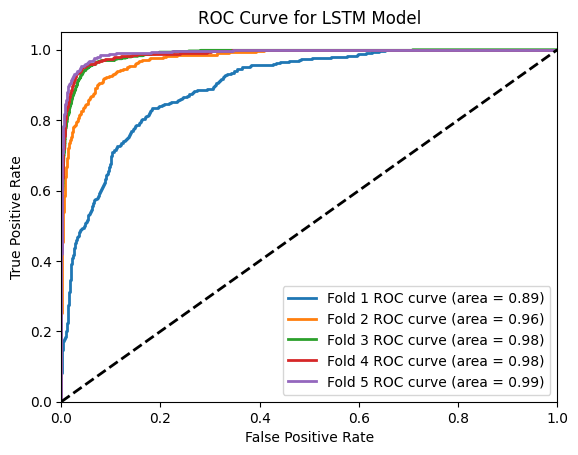

In [ ]:

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores_lstm = []
inputs = Input(shape=(200,))
layer = Embedding(input_dim=max_words, output_dim=128, input_length=200)(inputs)
layer = Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.28))(layer)
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.30)(layer)
layer = Dense(32, activation='relu')(layer)
layer = Dropout(0.30)(layer)
layer = Dense(6, activation='sigmoid')(layer)
model = Model(inputs=inputs, outputs=layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_val_scores_f1 = []
lstm_val_scores_precision = []
lstm_val_scores_recall = []
lstm_val_scores_accuracy = []
lstm_roc_auc = []
lstm_fpr = []
lstm_tpr = []

for train_index, val_index in kf.split(X_train):
    print(train_index)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Adjust the input data to match max_len
    X_train_fold = pad_sequences_custom(X_train_fold, 200)
    X_val_fold = pad_sequences_custom(X_val_fold, 200)

    checkpoint = ModelCheckpoint('save_best_model_lstm.tf', monitor='val_loss', verbose=1, save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=1)

    history_lstm = model.fit(X_train_fold, y_train_fold, batch_size=128, epochs=5, validation_split=0.2, callbacks=[checkpoint, early_stop])

    # Evaluate the model
    val_preds = model.predict(X_val_fold)
    val_preds_binary = (val_preds > 0.5).astype(int)
    
    f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
    precision = precision_score(y_val_fold, val_preds_binary, average='macro')
    recall = recall_score(y_val_fold, val_preds_binary, average='macro')
    accuracy = accuracy_score(y_val_fold, val_preds_binary)

    lstm_val_scores_f1.append(f1)
    lstm_val_scores_precision.append(precision)
    lstm_val_scores_recall.append(recall)
    lstm_val_scores_accuracy.append(accuracy)
    # Calculate ROC AUC for all classes together
    auc2 = roc_auc_score(y_val_fold, val_preds, average='macro')
    fpr, tpr, _ = roc_curve(y_val_fold.ravel(), val_preds.ravel())
    lstm_roc_auc.append(auc2)
    lstm_fpr.append(fpr)
    lstm_tpr.append(tpr)


# Plot ROC curves for all classes together
plt.figure()

# Plot each fold's ROC curve
for i in range(len(lstm_fpr)):  # Each fold
    plt.plot(lstm_fpr[i], lstm_tpr[i], lw=2, label=f'Fold {i+1} ROC curve (area = {lstm_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Model')
plt.legend(loc="lower right")
plt.show()

CNN

[    1     2     4 ... 12758 12763 12765]
Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.4498
Epoch 1: val_loss improved from inf to 0.10658, saving model to best_model_cnn.tf
INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



80/80 [==============================] - 30s 359ms/step - loss: 0.2007 - accuracy: 0.4498 - val_loss: 0.1066 - val_accuracy: 0.9186
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.6239
Epoch 2: val_loss improved from 0.10658 to 0.09577, saving model to best_model_cnn.tf
INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



80/80 [==============================] - 26s 331ms/step - loss: 0.1077 - accuracy: 0.6239 - val_loss: 0.0958 - val_accuracy: 0.9511
Epoch 3/5
80/80 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.6847
Epoch 3: val_loss improved from 0.09577 to 0.06045, saving model to best_model_cnn.tf
INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



80/80 [==============================] - 29s 358ms/step - loss: 0.0642 - accuracy: 0.6847 - val_loss: 0.0605 - val_accuracy: 0.9953
Epoch 4/5
80/80 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.8096
Epoch 4: val_loss did not improve from 0.06045
80/80 [==============================] - 25s 313ms/step - loss: 0.0418 - accuracy: 0.8096 - val_loss: 0.0694 - val_accuracy: 0.9953
Epoch 5/5
80/80 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.8081
Epoch 5: val_loss did not improve from 0.06045
80/80 [==============================] - 26s 324ms/step - loss: 0.0339 - accuracy: 0.8081 - val_loss: 0.0751 - val_accuracy: 0.9953
Epoch 5: early stopping
80/80 [==============================] - 2s 25ms/step
[    0     1     2 ... 12762 12763 12764]


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.7501
Epoch 1: val_loss improved from inf to 0.02866, saving model to best_model_cnn.tf
INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



80/80 [==============================] - 27s 333ms/step - loss: 0.0419 - accuracy: 0.7501 - val_loss: 0.0287 - val_accuracy: 0.9953
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.7707
Epoch 2: val_loss did not improve from 0.02866
80/80 [==============================] - 25s 310ms/step - loss: 0.0299 - accuracy: 0.7707 - val_loss: 0.0308 - val_accuracy: 0.9953
Epoch 3/5
80/80 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.7529
Epoch 3: val_loss did not improve from 0.02866
80/80 [==============================] - 25s 306ms/step - loss: 0.0255 - accuracy: 0.7529 - val_loss: 0.0288 - val_accuracy: 0.9918
Epoch 3: early stopping
80/80 [==============================] - 2s 21ms/step
[    0     1     2 ... 12763 12764 12765]


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.6448
Epoch 1: val_loss improved from inf to 0.02440, saving model to best_model_cnn.tf
INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



80/80 [==============================] - 25s 317ms/step - loss: 0.0250 - accuracy: 0.6448 - val_loss: 0.0244 - val_accuracy: 0.3772
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.5932
Epoch 2: val_loss improved from 0.02440 to 0.02216, saving model to best_model_cnn.tf
INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



80/80 [==============================] - 25s 316ms/step - loss: 0.0206 - accuracy: 0.5932 - val_loss: 0.0222 - val_accuracy: 0.8429
Epoch 3/5
80/80 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.5317
Epoch 3: val_loss did not improve from 0.02216
80/80 [==============================] - 25s 307ms/step - loss: 0.0172 - accuracy: 0.5317 - val_loss: 0.0226 - val_accuracy: 0.4054
Epoch 4/5
80/80 [==============================] - ETA: 0s - loss: 0.0158 - accuracy: 0.4311
Epoch 4: val_loss did not improve from 0.02216
80/80 [==============================] - 24s 305ms/step - loss: 0.0158 - accuracy: 0.4311 - val_loss: 0.0234 - val_accuracy: 0.4677
Epoch 4: early stopping
80/80 [==============================] - 2s 20ms/step
[    0     1     3 ... 12763 12764 12765]


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.4476
Epoch 1: val_loss improved from inf to 0.01355, saving model to best_model_cnn.tf
INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



80/80 [==============================] - 25s 316ms/step - loss: 0.0167 - accuracy: 0.4476 - val_loss: 0.0135 - val_accuracy: 0.3216
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.4132
Epoch 2: val_loss did not improve from 0.01355
80/80 [==============================] - 25s 306ms/step - loss: 0.0140 - accuracy: 0.4132 - val_loss: 0.0142 - val_accuracy: 0.2158
Epoch 3/5
80/80 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.3334
Epoch 3: val_loss did not improve from 0.01355
80/80 [==============================] - 24s 303ms/step - loss: 0.0119 - accuracy: 0.3334 - val_loss: 0.0145 - val_accuracy: 0.2103
Epoch 3: early stopping
80/80 [==============================] - 2s 20ms/step
[    0     2     3 ... 12762 12764 12765]


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.3306
Epoch 1: val_loss improved from inf to 0.01091, saving model to best_model_cnn.tf
INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



80/80 [==============================] - 26s 319ms/step - loss: 0.0125 - accuracy: 0.3306 - val_loss: 0.0109 - val_accuracy: 0.2530
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.3321
Epoch 2: val_loss improved from 0.01091 to 0.00966, saving model to best_model_cnn.tf
INFO:tensorflow:Assets written to: best_model_cnn.tf\assets


INFO:tensorflow:Assets written to: best_model_cnn.tf\assets



80/80 [==============================] - 26s 323ms/step - loss: 0.0123 - accuracy: 0.3321 - val_loss: 0.0097 - val_accuracy: 0.3255
Epoch 3/5
80/80 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.3463
Epoch 3: val_loss did not improve from 0.00966
80/80 [==============================] - 25s 307ms/step - loss: 0.0111 - accuracy: 0.3463 - val_loss: 0.0097 - val_accuracy: 0.4614
Epoch 4/5
80/80 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.3652
Epoch 4: val_loss did not improve from 0.00966
80/80 [==============================] - 24s 303ms/step - loss: 0.0094 - accuracy: 0.3652 - val_loss: 0.0105 - val_accuracy: 0.2895
Epoch 4: early stopping
80/80 [==============================] - 2s 19ms/step


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


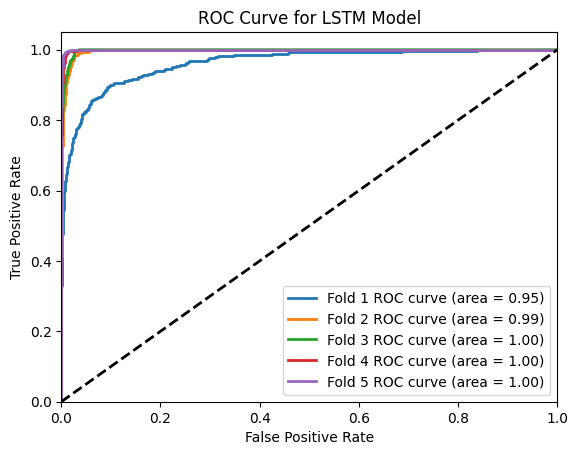

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_scores_cnn = []

# Define the CNN model
inputs = Input(shape=(200,))
embedding = Embedding(input_dim=max_words, output_dim=256, input_length=200)(inputs)
conv1 = Conv1D(filters=256, kernel_size=3, activation='relu')(embedding)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=256, kernel_size=3, activation='relu')(pool1)
pool2 = GlobalMaxPooling1D()(conv2)
dense1 = Dense(64, activation='relu')(pool2)
dropout = Dropout(0.20)(dense1)
outputs = Dense(6, activation='sigmoid')(dropout)
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_val_scores_f1 = []
cnn_val_scores_precision = []
cnn_val_scores_recall = []
cnn_val_scores_accuracy = []
cnn_roc_auc = []
cnn_fpr = []
cnn_tpr = []

for train_index, val_index in kf.split(X_train):
    print(train_index)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Adjust the input data to match max_len
    X_train_fold = pad_sequences_custom(X_train_fold, 200)
    X_val_fold = pad_sequences_custom(X_val_fold, 200)
    
    # Define callbacks
    checkpoint = ModelCheckpoint('best_model_cnn.tf', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)

    # Train the model
    history_cnn = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=128, validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop])

    # Evaluate the model
    val_preds = model.predict(X_val_fold)
    val_preds_binary = (val_preds > 0.5).astype(int)

    f1 = f1_score(y_val_fold, val_preds_binary, average='macro')
    precision = precision_score(y_val_fold, val_preds_binary, average='macro')
    recall = recall_score(y_val_fold, val_preds_binary, average='macro')
    accuracy = accuracy_score(y_val_fold, val_preds_binary)

    cnn_val_scores_f1.append(f1)
    cnn_val_scores_precision.append(precision)
    cnn_val_scores_recall.append(recall)
    cnn_val_scores_accuracy.append(accuracy)
    # Calculate ROC AUC for all classes together
    auc2 = roc_auc_score(y_val_fold, val_preds, average='macro')
    fpr, tpr, _ = roc_curve(y_val_fold.ravel(), val_preds.ravel())
    cnn_roc_auc.append(auc2)
    cnn_fpr.append(fpr)
    cnn_tpr.append(tpr)

# Plot ROC curves for all classes together
plt.figure()

# Plot each fold's ROC curve
for i in range(len(cnn_fpr)):  # Each fold
    plt.plot(cnn_fpr[i], cnn_tpr[i], lw=2, label=f'Fold {i+1} ROC curve (area = {cnn_roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN Model')
plt.legend(loc="lower right")
plt.show()
    

4987/4987 [==============================] - 157s 31ms/step
Test F1 Score: 0.4534777010356099
Test Precision: 0.5259462866472722
Test Recall: 0.4200830107480236
Test Accuracy: 0.8985467284155643
Test ROC AUC: 0.9469749784036882


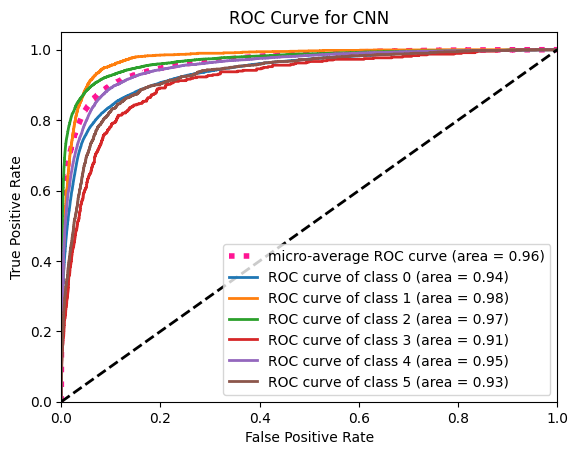

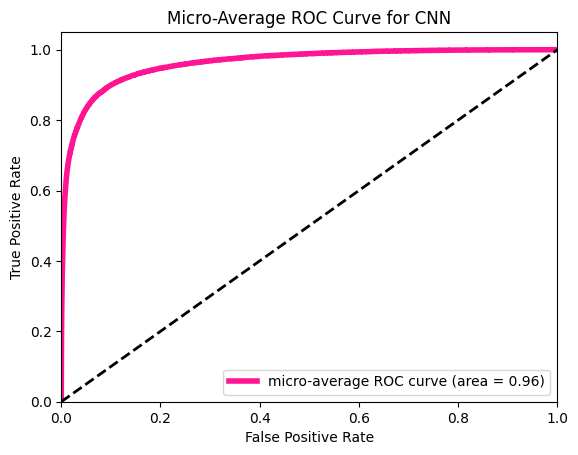

In [ ]:
#CNN
# Test the model on X_test
best_model = load_model('best_model_cnn.tf')
X_test_padded = pad_sequences_custom(X_test_data_padded, 200)
test_preds = best_model.predict(X_test_padded)
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate metrics on test data
test_f1 = f1_score(y_test_binary, test_preds_binary, average='macro')
test_precision = precision_score(y_test_binary, test_preds_binary, average='macro')
test_recall = recall_score(y_test_binary, test_preds_binary, average='macro')
test_accuracy = accuracy_score(y_test_binary, test_preds_binary)
test_auc = roc_auc_score(y_test_binary, test_preds, average='macro')

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

# Calculate ROC curve and AUC for each label and then average
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binary.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), test_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                      ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN')
plt.legend(loc="lower right")

# Save the first plot to a PNG file
plt.savefig('roc_curve_multiclass_cnn.png')
plt.show()

# Plot micro-average ROC curve separately
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve for CNN')
plt.legend(loc="lower right")

# Save the second plot to a PNG file
plt.savefig('roc_curve_micro_cnn.png')
plt.show()

4987/4987 [==============================] - 477s 96ms/step


C:\Users\Ja\PycharmProjects\ProjektNWPython8\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test F1 Score: 0.3448282798819026
Test Precision: 0.39152046109665334
Test Recall: 0.30873895646706956
Test Accuracy: 0.9071573155523247
Test ROC AUC: 0.9514668918060784


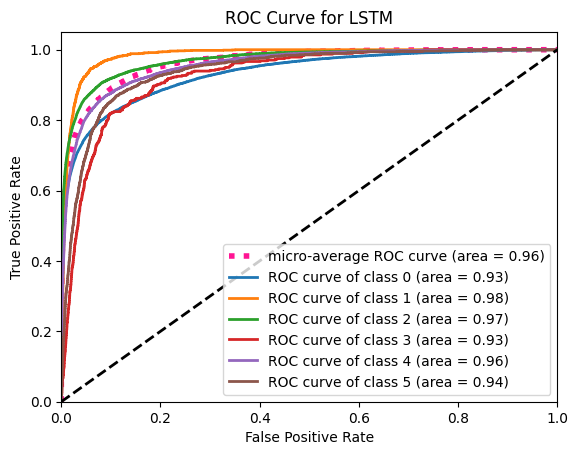

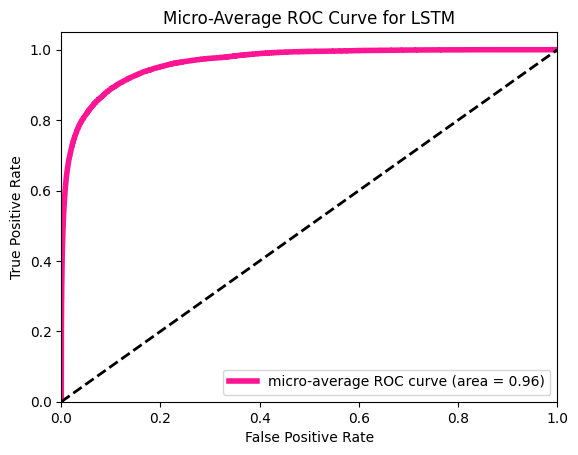

In [ ]:
# Load the model and prepare the test data
best_model = load_model('save_best_model_lstm.tf')
X_test_padded = pad_sequences_custom(X_test_data_padded, 200)
test_preds = best_model.predict(X_test_padded)
test_preds_binary = (test_preds > 0.5).astype(int)

# Calculate metrics on test data
test_f1 = f1_score(y_test_binary, test_preds_binary, average='macro')
test_precision = precision_score(y_test_binary, test_preds_binary, average='macro')
test_recall = recall_score(y_test_binary, test_preds_binary, average='macro')
test_accuracy = accuracy_score(y_test_binary, test_preds_binary)
test_auc = roc_auc_score(y_test_binary, test_preds, average='macro')

print('Test F1 Score:', test_f1)
print('Test Precision:', test_precision)
print('Test Recall:', test_recall)
print('Test Accuracy:', test_accuracy)
print('Test ROC AUC:', test_auc)

# Calculate ROC curve and AUC for each label and then average
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binary.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), test_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                      ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM')
plt.legend(loc="lower right")

# Save the first plot to a PNG file
plt.savefig('roc_curve_multiclass_lstm.png')
plt.show()

# Plot micro-average ROC curve separately
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve for LSTM')
plt.legend(loc="lower right")

# Save the second plot to a PNG file
plt.savefig('roc_curve_micro_lstm.png')
plt.show()

Best parameters from RandomizedSearchCV: {'estimator__C': 9.51714306409916, 'estimator__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.92      0.53      0.67      1220
           1       0.52      0.20      0.29       137
           2       0.92      0.57      0.70       696
           3       0.60      0.08      0.14        38
           4       0.80      0.46      0.59       660
           5       0.59      0.09      0.15       116

   micro avg       0.88      0.48      0.62      2867
   macro avg       0.73      0.32      0.42      2867
weighted avg       0.86      0.48      0.61      2867
 samples avg       0.05      0.04      0.04      2867


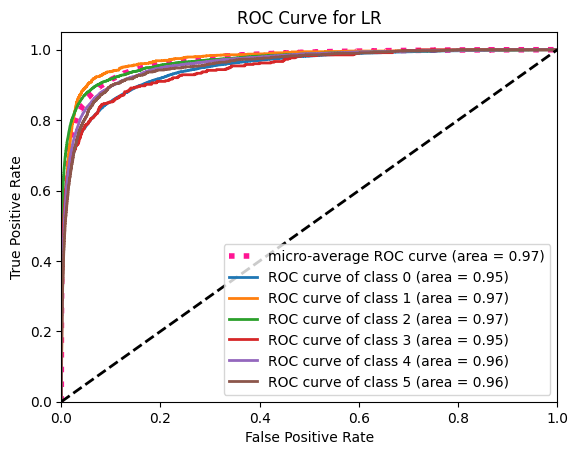

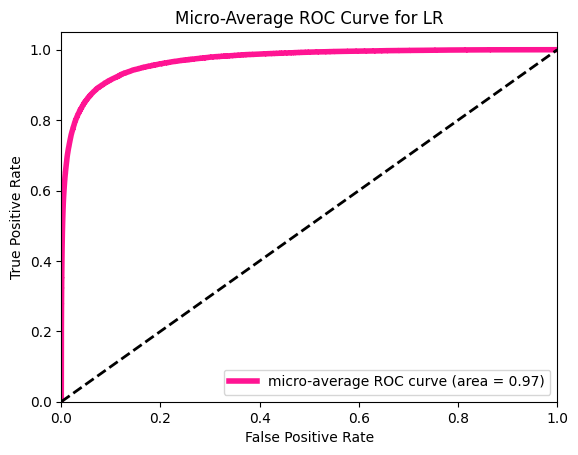

In [ ]:
param_distributions = {
    'estimator__C': uniform(loc=0.01, scale=10),
    'estimator__penalty': ['l2']
}

estimator_LR = MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, verbose=True))

random_search_LR = RandomizedSearchCV(
    estimator=estimator_LR,
    param_distributions=param_distributions,
    n_iter=4,
    cv=3,
    random_state=42,
    scoring='f1_weighted'
)

def remove_prefix(d, prefix='estimator__'):
    return {k[len(prefix):]: v for k, v in d.items() if k.startswith(prefix)}

def LR_Training_CV(y_label, X_padded, tokenizer, k=5):
    # Perform parameter search on the entire dataset
    X_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_padded]
    
    tfidf_vec = TfidfVectorizer(max_df=0.7)
    X_vec = tfidf_vec.fit_transform(X_text)
    
    random_search_LR.fit(X_vec, y_label)
    best_params = random_search_LR.best_params_
    print('Best parameters from RandomizedSearchCV:', best_params)
    
    # Clean the best parameters
    cleaned_params = remove_prefix(best_params)
    
    # Use the best parameters for cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    all_predictions = []
    all_y_tests = []
    modelLR = MultiOutputClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, verbose=True, **cleaned_params))

    for train_index, test_index in kf.split(X_padded):
        X_train_LR, X_test_LR = X_padded[train_index], X_padded[test_index]
        y_train_LR, y_test_LR = y_label[train_index], y_label[test_index]
        
        X_train_LR = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_train_LR]
        X_test_LR = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_LR]
        
        X_train_LR_vec = tfidf_vec.fit_transform(X_train_LR)
        X_test_LR_vec = tfidf_vec.transform(X_test_LR)
        
        modelLR.fit(X_train_LR_vec, y_train_LR)
        
        predictions = modelLR.predict(X_test_LR_vec)
        
        all_predictions.extend(predictions)
        all_y_tests.extend(y_test_LR)
    
    # Print classification report
    print(classification_report(all_y_tests, all_predictions, zero_division=0))
    accuracy = accuracy_score(all_y_tests, all_predictions)
    report = classification_report(all_y_tests, all_predictions, output_dict=True, zero_division=0)

    return modelLR, tfidf_vec

# Trenuj model LR
modelLR, tfidf_vec_LR = LR_Training_CV(y_train, X_train, tokenizer)

# Prepare test data
X_test_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_data_padded]
X_test_vec = tfidf_vec_LR.transform(X_test_text)

# Predict on test data
test_preds = modelLR.predict_proba(X_test_vec)

# Convert list of arrays to a single array
test_preds_array = np.array([pred[:, 1] for pred in test_preds]).T

# Calculate ROC curve and AUC for each label and then average
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binary.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], test_preds_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), test_preds_array.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                      ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LR')
plt.legend(loc="lower right")
plt.savefig('roc_curve_multiclass_LR.png')
plt.show()

# Plot micro-average ROC curve separately
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve for LR')
plt.legend(loc="lower right")
plt.savefig('roc_curve_micro_LR.png')
plt.show()


Best parameters from RandomizedSearchCV: {'estimator__alpha': 0.1834347898661638, 'estimator__fit_prior': False}
              precision    recall  f1-score   support

           0       0.52      0.79      0.63      1220
           1       0.14      0.64      0.22       137
           2       0.40      0.77      0.53       696
           3       0.03      0.34      0.06        38
           4       0.38      0.75      0.51       660
           5       0.09      0.48      0.15       116

   micro avg       0.35      0.75      0.48      2867
   macro avg       0.26      0.63      0.35      2867
weighted avg       0.42      0.75      0.53      2867
 samples avg       0.06      0.07      0.06      2867

Accuracy: 0.8393388688704371


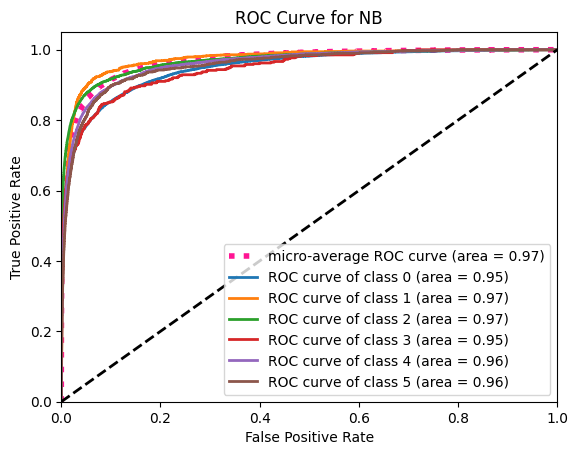

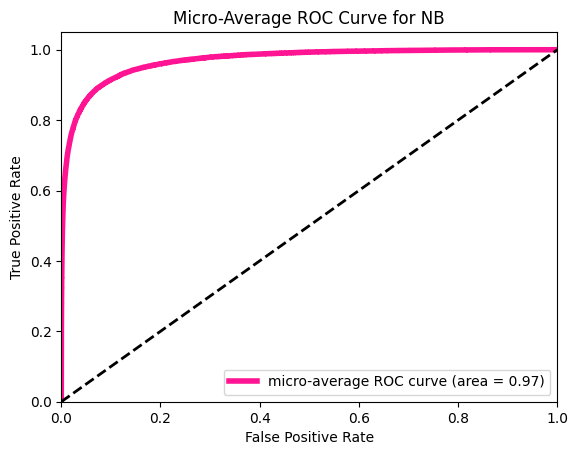

In [ ]:
param_distributions = {
    'estimator__alpha': uniform(loc=0, scale=1),
    'estimator__fit_prior': [True, False]
}

estimator_NB = MultiOutputClassifier(MultinomialNB())

random_search_NB = RandomizedSearchCV(
    estimator=estimator_NB,
    param_distributions=param_distributions,
    n_iter=4,
    cv=3,
    random_state=42,
    scoring='f1_weighted'
)

def NB_Training_CV(y_label, X_padded, tokenizer, k=5):
    # Perform parameter search on the entire dataset
    X_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_padded]

    tfidf_vec = TfidfVectorizer(max_df=0.7)
    X_vec = tfidf_vec.fit_transform(X_text)

    random_search_NB.fit(X_vec, y_label)
    best_params = random_search_NB.best_params_
    print('Best parameters from RandomizedSearchCV:', best_params)
    
    cleaned_params = remove_prefix(best_params)

    # Use the best parameters for cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    all_predictions = []
    all_y_tests = []
    modelNB = MultiOutputClassifier(MultinomialNB(**cleaned_params))
    for train_index, test_index in kf.split(X_padded):
        X_train_NB, X_test_NB = X_padded[train_index], X_padded[test_index]
        y_train_NB, y_test_NB = y_label[train_index], y_label[test_index]

        X_train_NB = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_train_NB]
        X_test_NB = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_NB]

        X_train_NB_vec = tfidf_vec.fit_transform(X_train_NB)
        X_test_NB_vec = tfidf_vec.transform(X_test_NB)

        modelNB.fit(X_train_NB_vec, y_train_NB)

        predictions = modelNB.predict(X_test_NB_vec)

        all_predictions.extend(predictions)
        all_y_tests.extend(y_test_NB)

    # Print classification report
    print(classification_report(all_y_tests, all_predictions, zero_division=0))
    
    # Calculate and return metrics
    report = classification_report(all_y_tests, all_predictions, output_dict=True, zero_division=0)
    accuracy = accuracy_score(all_y_tests, all_predictions)
    print('Accuracy:', accuracy)
    return modelNB, tfidf_vec

# Trenuj model NB
modelNB, tfidf_vec_NB = NB_Training_CV(y_train, X_train, tokenizer)

# Prepare test data
X_test_text = [' '.join(tokenizer.sequences_to_texts([comment])[0].split()) for comment in X_test_data_padded]
X_test_vec = tfidf_vec_NB.transform(X_test_text)

# Predict on test data
test_preds = modelLR.predict_proba(X_test_vec)

# Convert list of arrays to a single array
test_preds_array = np.array([pred[:, 1] for pred in test_preds]).T

# Calculate ROC curve and AUC for each label and then average
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binary.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], test_preds_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), test_preds_array.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                                      ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NB')
plt.legend(loc="lower right")
plt.savefig('roc_curve_multiclass_NB.png')
plt.show()

# Plot micro-average ROC curve separately
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve for NB')
plt.legend(loc="lower right")
plt.savefig('roc_curve_micro_NB.png')
plt.show()



In [4]:
results_metrics = {
    'Regresja_Liniowa': {
        'accuracy': [],
        'precision': [ 0.86, 0.53, 0.88, 0.63, 0.77],
        'recall': [0.67, 0.30, 0.69, 0.25, 0.56],
        'f1_score': [0.76, 0.38, 0.77, 0.35, 0.65]
    },
    'Naive_Bayes': {
        'accuracy': [],
        'precision': [0.91, 0.64, 0.89, 0.82, 0.75],
        'recall': [0.51, 0.09, 0.51, 0.43, 0.04],
        'f1_score': [0.66, 0.16, 0.65, 0.56, 0.08]
    },
    'CNN': {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    },
    'LSTM': {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
}

results_metrics['LSTM']['accuracy']=lstm_val_scores_accuracy
results_metrics['LSTM']['precision']=lstm_val_scores_precision
results_metrics['LSTM']['recall']=lstm_val_scores_recall
results_metrics['LSTM']['f1_score']=lstm_val_scores_f1

results_metrics['CNN']['accuracy']=cnn_val_scores_accuracy
results_metrics['CNN']['precision']=cnn_val_scores_precision
results_metrics['CNN']['recall']=cnn_val_scores_recall
results_metrics['CNN']['f1_score']=cnn_val_scores_f1

print(results_metrics)
# Calculate standard deviation for each metric in each model
std_devs = {model: {metric: np.std(values) for metric, values in metrics.items() if values} for model, metrics in results_metrics.items()}
std_devs

NameError: name 'lstm_val_scores_accuracy' is not defined

In [ ]:
def perform_t_tests_to_df(results_metrics, metric, alpha=0.05):
    models = list(results_metrics.keys())
    n_models = len(models)
    n_comparisons = (n_models * (n_models - 1)) / 2
    bonferroni_alpha = alpha / n_comparisons
    results = []

    for i in range(n_models):
        for j in range(i + 1, n_models):
            model_1 = models[i]
            model_2 = models[j]
            scores_1 = results_metrics[model_1][metric]
            scores_2 = results_metrics[model_2][metric]
            differences = [a - b for a, b in zip(scores_1, scores_2)]
            
            # Perform the Shapiro-Wilk test for normality
            shapiro_stat, shapiro_p_value = shapiro(differences)
            
            if shapiro_p_value > 0.05:
                # If the p-value is greater than 0.05, we assume normality and use t-test
                t_stat, p_value = ttest_rel(scores_1, scores_2)
                test_used = 't-test'
            else:
                # If the p-value is less than or equal to 0.05, we use the Wilcoxon signed-rank test
                t_stat, p_value = wilcoxon(scores_1, scores_2)
                test_used = 'wilcoxon'
                
            results.append({
                'Metric': metric,
                'Model 1': model_1,
                'Model 2': model_2,
                'Test': test_used,
                't-stat': t_stat,
                'p-value': p_value,
                'Corrected p-value': p_value * n_comparisons,
                'Significant': p_value < bonferroni_alpha,
                'Normality p-value': shapiro_p_value
            })

    return pd.DataFrame(results)

# Przeprowadzenie t-testów dla precision, recall i f1-score i zapis wyników do DataFrame
df_precision = perform_t_tests_to_df(results_metrics, 'precision')
df_recall = perform_t_tests_to_df(results_metrics, 'recall')
df_f1_score = perform_t_tests_to_df(results_metrics, 'f1_score')

# Połączenie wyników w jeden DataFrame
df_results = pd.concat([df_precision, df_recall, df_f1_score], ignore_index=True)

# Zapis wyników do pliku LaTeX
latex_table = df_results.to_latex(index=False, float_format="%.4f")

print(latex_table)

# Zapis tabeli LaTeX do pliku
with open('t_test_results.tex', 'w') as f:
    f.write(latex_table)

\begin{tabular}{llllrrrrr}
\toprule
Metric & Model 1 & Model 2 & Test & t-stat & p-value & Corrected p-value & Significant & Normality p-value \\
\midrule
precision & Regresja_Liniowa & Naive_Bayes & t-test & -1.8148 & 0.1437 & 0.8625 & False & 0.7689 \\
precision & Regresja_Liniowa & CNN & t-test & 1.1580 & 0.3113 & 1.8677 & False & 0.2658 \\
precision & Regresja_Liniowa & LSTM & t-test & 3.8647 & 0.0181 & 0.1084 & False & 0.7772 \\
precision & Naive_Bayes & CNN & t-test & 2.3932 & 0.0749 & 0.4494 & False & 0.3750 \\
precision & Naive_Bayes & LSTM & t-test & 5.2468 & 0.0063 & 0.0379 & True & 0.5773 \\
precision & CNN & LSTM & t-test & 6.2189 & 0.0034 & 0.0204 & True & 0.3381 \\
recall & Regresja_Liniowa & Naive_Bayes & t-test & 1.6034 & 0.1841 & 1.1047 & False & 0.5583 \\
recall & Regresja_Liniowa & CNN & t-test & -0.4577 & 0.6709 & 4.0256 & False & 0.7778 \\
recall & Regresja_Liniowa & LSTM & t-test & 1.2600 & 0.2762 & 1.6569 & False & 0.8132 \\
recall & Naive_Bayes & CNN & t-test & 